In [93]:
using DataFrames
using Requests
using TimeSeries
using MarketTechnicals
using PyPlot

In [94]:
function getcsv(url)
    # without error checking
    df = readtable(Requests.get_streaming(url))
end
function csvtotimearray(url)
    df = getcsv(url)
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    dataarray=convert(Array, df[2:end])
    TimeArray(timestamp,dataarray,colnames[2:end])
end
# function csvtotimearray_adjustclose(url)
#     df = getcsv(url)
#     timestamp = Date[Date(i) for i in df[1]] # parse dates
#     colnames=AbstractString[string(i) for i in DataFrames.names(df)]
#     dataarray=convert(Array, df[[2,3,4,7,6]])
#     TimeArray(timestamp,dataarray,colnames[2:end-1])
# end
function yahoo(symbol, startdate)
    str="a="*string(Dates.month(startdate)-1)*Dates.format(startdate, "&b=dd&c=yyyy")
    url="http://real-chart.finance.yahoo.com/table.csv?s="*symbol*"&"*str*"&g=d&ignore=.csv"
    csvtotimearray(url)
end
function quandl(symbol, startdate)
    str=Dates.format(startdate, "yyyy-mm-dd")
    url="https://www.quandl.com/api/v3/datasets/"*symbol*".csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date="*str
    csvtotimearray(url)
end

quandl (generic function with 1 method)

In [95]:
symbol="QQQ"
startdate=Date(2007,1,1)
ohlcv=yahoo(symbol, startdate)

1742x6 TimeSeries.TimeArray{Real,2,DataType} 2009-06-08 to 2016-05-06

             Open      High      Low       Close     Volume          Adj_Close  
2009-06-08 | 36.55     36.95     36.12     36.67     89194100        34.03      
2009-06-09 | 36.84     37.17     36.67     36.95     109187800       34.2902    
2009-06-10 | 37.16     37.17     36.29     36.82     133404700       34.1696    
2009-06-11 | 36.77     37.23     36.75     36.82     147909800       34.1696    
⋮
2016-05-03 | 105.96    106.44    105.45    105.73    36351400        105.73     
2016-05-04 | 105.12    105.48    104.79    105.05    26689000        105.05     
2016-05-05 | 105.43    105.66    104.81    105.02    20724800        105.02     
2016-05-06 | 104.5     105.6     104.4     105.58    29731500        105.58     


In [96]:
# ohlcv=quandl("GOOG/NASDAQ_QQQ",startdate)

In [97]:
ta=ohlcv["Close"]
vix=quandl("CBOE/VIX", startdate)
vixarray=TimeArray(vix.timestamp,vix.values[:,end],[vix.colnames[end]])

2352x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-01-03 to 2016-05-05

             VIX_Close  
2007-01-03 | 12.04      
2007-01-04 | 11.51      
2007-01-05 | 12.14      
2007-01-08 | 12.0       
⋮
2016-05-02 | 14.68      
2016-05-03 | 15.6       
2016-05-04 | 16.05      
2016-05-05 | 15.91      


In [98]:
ustreasuryarray=quandl("USTREASURY/REALLONGTERM", startdate)

2341x1 TimeSeries.TimeArray{Float64,2,DataType} 2007-01-02 to 2016-05-06

             LT_Real_Average_10Yrs_  
2007-01-02 | 2.33                    
2007-01-03 | 2.32                    
2007-01-04 | 2.3                     
2007-01-05 | 2.33                    
⋮
2016-05-03 | 0.67                    
2016-05-04 | 0.66                    
2016-05-05 | 0.62                    
2016-05-06 | 0.66                    


In [99]:
oil=quandl("EOD/OIL", startdate)
oilarray=TimeArray(oil.timestamp,oil.values[:,end-1],["oil"])

2353x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-01-03 to 2016-05-06

             oil      
2007-01-03 | 36.38    
2007-01-04 | 34.88    
2007-01-05 | 35.13    
2007-01-08 | 35.0999  
⋮
2016-05-03 | 5.67     
2016-05-04 | 5.7      
2016-05-05 | 5.77     
2016-05-06 | 5.8      


In [100]:
gold=quandl("WGC/GOLD_DAILY_USD", startdate)
gold2=TimeArray(gold.timestamp,gold.values[:,end],["gold"])
goldarray=gold2./gold2.values[1]

2440x1 TimeSeries.TimeArray{Float64,1,DataType} 2007-01-01 to 2016-05-06

             gold    
2007-01-01 | 1.0     
2007-01-02 | 1.0123  
2007-01-03 | 1.0168  
2007-01-04 | 0.9948  
⋮
2016-05-03 | 2.0475  
2016-05-04 | 2.0301  
2016-05-05 | 2.0258  
2016-05-06 | 2.0396  


In [101]:
predictcount=252
rangelength=28

28

In [102]:
function volumeoscillator(ohlcv, n=28, c="Volume")
    volume=ohlcv[c]
    vshort=ema(volume, Int(n/2))
    vlong=ema(volume, n)
    volumeoscillator=(vshort.-vlong)./vlong
    TimeArray(volumeoscillator.timestamp,volumeoscillator.values,["VolumeOscillator"])
end

volumeoscillator (generic function with 3 methods)

In [103]:
function averagetruerange(ohlc, n=14, h="High", l="Low", c="Close")
    highs = merge(ohlc[h], lag(ohlc[c]))
    lows = merge(ohlc[l], lag(ohlc[c]))
    hi=convert(Array{Real,1},[maximum(highs.values[i,:]) for i=1:size(highs.values)[1]])
    lo=convert(Array{Real,1},[minimum(lows.values[i,:]) for i=1:size(lows.values)[1]])
    truehigh = TimeArray(highs.timestamp, hi, ["hi"], highs.meta)
    truelow  = TimeArray(lows.timestamp, lo, ["lo"], lows.meta)
    res = ema(truehigh .- truelow, n, wilder=true)
    TimeArray(res.timestamp, res.values, ["atr"*string(n)], ohlc.meta)
end

averagetruerange (generic function with 5 methods)

In [104]:
function macd2(ta, fast=12, slow=26, signal=9)
    mcd = ema(ta, fast) .- ema(ta, slow)
    sig = ema(mcd, signal)
    merge(mcd, sig, col_names=["macd", "signal"])
end

macd2 (generic function with 4 methods)

In [105]:
function moneyflowindex(ohlcv, n=14, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pflow=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nflow=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pflow,sum,n)
    nsum=moving(nflow,sum,n)
    flowsum=psum.+nsum
    re=psum./flowsum
    TimeArray(re.timestamp, re.values, ["mfi"], ohlcv.meta)
end

moneyflowindex (generic function with 6 methods)

In [106]:
function chaikinmoneyflow(ohlcv, n=21, h="High", l="Low", c="Close", v="Volume")
    high=ohlcv[h]
    low=ohlcv[l]
    clo=ohlcv[c]
    volume=ohlcv[v]
    moneyflowvolume = (2.*clo.-low.-high)./(high.-low).*volume
    moneyflowsum=moving(moneyflowvolume,sum,n)
    volumesum=moving(volume,sum,n)
    re=moneyflowsum./volumesum
    TimeArray(re.timestamp, re.values, ["cmf"*string(n)], ohlcv.meta)
end

chaikinmoneyflow (generic function with 6 methods)

In [107]:
function overlaps(t1::Vector, t2::Vector)
    i = j = 1
    idx1 = Int[]
    idx2 = Int[]
    while i <= length(t1) && j <= length(t2)
        if t1[i] > t2[j]
            j += 1
        elseif t1[i] < t2[j]
            i += 1
        else
            push!(idx1, i)
            push!(idx2, j)
            i += 1
            j += 1
        end
    end
    (idx1, idx2)        
end

overlaps (generic function with 1 method)

In [108]:
function mergetimearray(ta1, ta2)
    idx1, idx2 = overlaps(ta1.timestamp, ta2.timestamp)
    vals = [ta1[idx1].values ta2[idx2].values]
    TimeArray(ta1[idx1].timestamp, vals, [ta1.colnames; ta2.colnames])
end

mergetimearray (generic function with 1 method)

In [109]:
function pricerangeindex(ta, n=28)
    high=moving(ta, maximum, n)
    low=moving(ta, minimum, n)
    lh=merge(low, high, col_names = ["min", "max"])
    lh2=lh
    for i=1:n-1
        lh2=lead(lh2)
    end
    ranges=mergetimearray(ta,lh2)
    index=[Real((i[2][1]-i[2][2])/(i[2][3]-i[2][2])) for i in ranges]
    TimeArray(ranges.timestamp, [ranges.values index], [ranges.colnames;["pricerange"*string(n)]])
end

pricerangeindex (generic function with 2 methods)

In [110]:
function bollingerbands2{T,N}(ta::TimeArray{T,N}, ma::Int, width::Real)
    tama   = sma(ta, ma)
    upband = tama .+ moving(ta, std, ma) .* width .* sqrt((ma-1)/ma) # take out Bessel correction, per algorithm
    dnband = tama .- moving(ta, std, ma) .* width .* sqrt((ma-1)/ma)
    bands  =  merge(upband, dnband) 
    merge(bands, tama, col_names = ["up", "down", "mean"])
end

bollingerbands2 (generic function with 1 method)

In [111]:
function bollingerbands_deviation(ta, n=20, width=2)
    bbands=bollingerbands2(ta,n,width)
    bbprice=mergetimearray(bbands,ta)
    bbstd=(bbands.values[:,1].-bbands.values[:,3])./2
    bbdev=(bbprice.values[:,4].-bbands.values[:,3])./(bbands.values[:,1].-bbands.values[:,3])
    TimeArray(bbands.timestamp, [bbdev bbstd], ["bbdev"*string(n)*","*string(width), "bbstd"*string(n)*","*string(width)])
end

bollingerbands_deviation (generic function with 3 methods)

In [112]:
function moneyflow_divergence(rsi, mfi, n=14)
    rm=mergetimearray(rsi,mfi)
    diff=rm.values[:,2].-rm.values[:,1]
    mfdev=TimeArray(rm.timestamp,diff,["moneyflowdev"])
    mfdevema=ema(mfdev,6)
    TimeArray(mfdevema.timestamp,mfdevema.values,["mfi_divergence_"*string(n)])
end

moneyflow_divergence (generic function with 2 methods)

In [113]:
function vwap_divergence(ohlcv, n=28)
    v1=vwap(ohlcv, Int(n/2))
    v2=vwap(ohlcv, n)
    v3=vwap(ohlcv, n*2)
    d1=v1.-v2
    d2=v2.-v3
    div=d1.-d2
    ta=mergetimearray(v1,v2)
    ta=mergetimearray(ta,v3)
    ta=mergetimearray(ta,d1)
    ta=mergetimearray(ta,d2)
    ta=mergetimearray(ta,div)
    cname=["vwap$(Int(n/2))","vwap$n","vwap$(n*2)","vwap$(Int(n/2))-$n","vwap$n-$(n*2)","vwap_2nd_divergence"]
    TimeArray(ta.timestamp,ta.values,cname)
end

vwap_divergence (generic function with 2 methods)

In [114]:
vwaparray=vwap_divergence(ohlcv, rangelength);

In [115]:
rsiarray=rsi(ta)./100;
rsiarray2=rsi(ta,rangelength)./100;

In [116]:
atrarray=averagetruerange(ohlcv);
atrarray2=averagetruerange(ohlcv,rangelength);

In [117]:
mfiarray=moneyflowindex(ohlcv);
mfiarray2=moneyflowindex(ohlcv,rangelength);

In [118]:
mfidivarray=moneyflow_divergence(rsiarray,mfiarray);
mfidivarray2=moneyflow_divergence(rsiarray2,atrarray2, rangelength);

In [119]:
volumeoscillatorarray=volumeoscillator(ohlcv, rangelength);
macdarray=macd2(ta);
cmfarray=chaikinmoneyflow(ohlcv);
bbarray=bollingerbands_deviation(ta);
rangeindexarray=pricerangeindex(ta, rangelength);

In [120]:
featurearray=mergetimearray(atrarray,rsiarray);
featurearray=mergetimearray(featurearray,mfiarray);
featurearray=mergetimearray(featurearray,mfidivarray);
featurearray=mergetimearray(featurearray,cmfarray);
featurearray=mergetimearray(featurearray,bbarray);
featurearray=mergetimearray(featurearray,macdarray);
featurearray=mergetimearray(featurearray,volumeoscillatorarray);

In [121]:
featurearray=mergetimearray(featurearray,atrarray2);
featurearray=mergetimearray(featurearray,rsiarray2);
featurearray=mergetimearray(featurearray,mfiarray2);
featurearray=mergetimearray(featurearray,mfidivarray2);
featurearray=mergetimearray(featurearray,ustreasuryarray);
featurearray=mergetimearray(featurearray,vixarray);
featurearray=mergetimearray(featurearray,vwaparray);
featurearray=mergetimearray(featurearray,goldarray);
featurearray=mergetimearray(featurearray,oilarray);

In [122]:
withlabel=mergetimearray(featurearray,rangeindexarray)

1646x28 TimeSeries.TimeArray{Real,2,DataType} 2009-08-25 to 2016-03-30

             atr14   rsi     mfi     mfi_divergence_14  cmf21   bbdev20,2  bbstd20,2  macd    signal  VolumeOscillator  atr28   rsi     mfi     mfi_divergence_28  LT_Real_Average_10Yrs_  VIX_Close  vwap14    vwap28    vwap56    vwap14-28  vwap28-56  vwap_2nd_divergence  gold    oil      Close     min       max       pricerange28  
2009-08-25 | 0.6654  0.6452  0.5458  -0.0776            0.0478  0.771      0.4553     0.5524  0.5787  -0.0309           0.6725  0.6118  0.6923  0.0918             2.15                    24.92      39.6561   39.3626   37.5757   0.2935     1.7868     -1.4933              1.504   24.57    40.37     39.25     42.65     0.3294        
2009-08-26 | 0.655   0.6268  0.5636  -0.0735            0.0688  0.6232     0.4686     0.5556  0.5741  -0.034            0.6671  0.6034  0.674   0.0838             2.13                    24.95      39.7204   39.4543   37.6297   0.2661     1.8246     -1.5586     

In [123]:
withoutlabel=mergetimearray(featurearray,ta)

1672x25 TimeSeries.TimeArray{Real,2,DataType} 2009-08-25 to 2016-05-05

             atr14   rsi     mfi     mfi_divergence_14  cmf21   bbdev20,2  bbstd20,2  macd    signal  VolumeOscillator  atr28   rsi     mfi     mfi_divergence_28  LT_Real_Average_10Yrs_  VIX_Close  vwap14    vwap28    vwap56    vwap14-28  vwap28-56  vwap_2nd_divergence  gold    oil      Close     
2009-08-25 | 0.6654  0.6452  0.5458  -0.0776            0.0478  0.771      0.4553     0.5524  0.5787  -0.0309           0.6725  0.6118  0.6923  0.0918             2.15                    24.92      39.6561   39.3626   37.5757   0.2935     1.7868     -1.4933              1.504   24.57    40.37     
2009-08-26 | 0.655   0.6268  0.5636  -0.0735            0.0688  0.6232     0.4686     0.5556  0.5741  -0.034            0.6671  0.6034  0.674   0.0838             2.13                    24.95      39.7204   39.4543   37.6297   0.2661     1.8246     -1.5586              1.4881  24.41    40.3      
2009-08-27 | 0.6654  0.6435  0.

In [124]:
dataoffset=length(withoutlabel)-length(withlabel)
lastdate=withlabel.timestamp[end]
lastdateidx=searchsortedfirst(withoutlabel.timestamp, lastdate)
splitidx=lastdateidx-predictcount+dataoffset
newfeatures=TimeArray(withoutlabel.timestamp[splitidx+1:end],withoutlabel.values[splitidx+1:end,:],withoutlabel.colnames);

In [125]:
training=TimeArray(withlabel.timestamp[1:splitidx],withlabel.values[1:splitidx,:],withlabel.colnames);

In [126]:
# test=TimeArray(withlabel.timestamp[splitidx+1:end],withlabel.values[splitidx+1:end,:],withlabel.colnames);

In [127]:
rsiidx=findlast(withlabel.colnames,"rsi")
mfiidx=findlast(withlabel.colnames,"mfi")
closeidx=findfirst(withlabel.colnames,"Close")

25

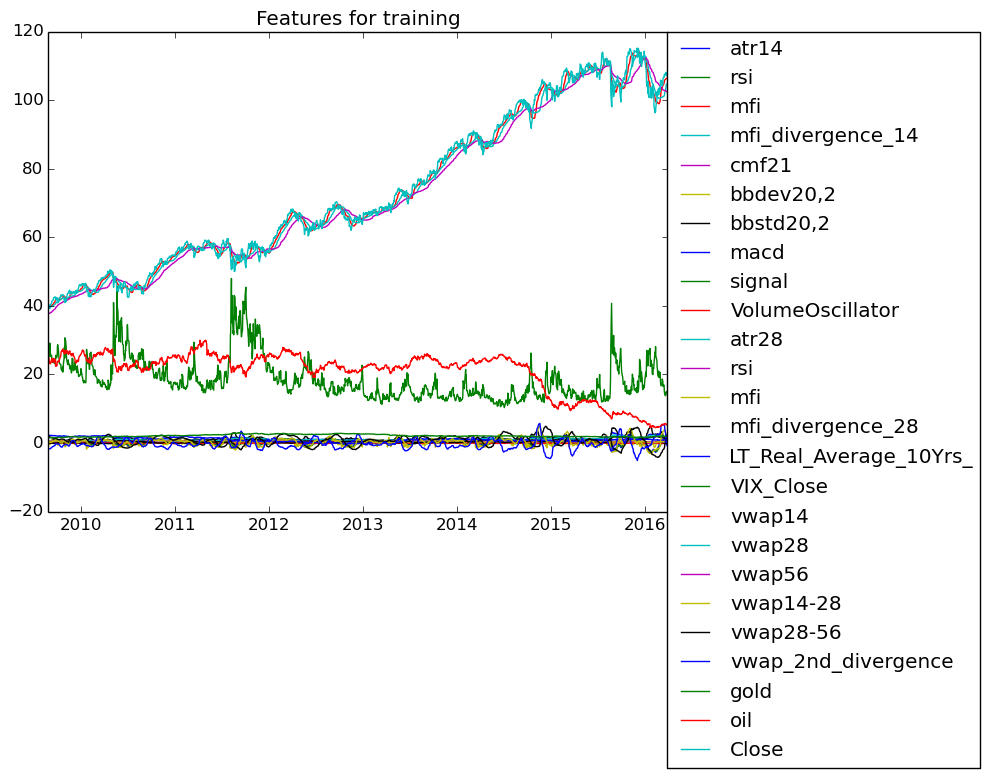

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [128]:
plot(withlabel.timestamp,withlabel.values[:,1:closeidx])
legend(withlabel.colnames[1:closeidx],bbox_to_anchor=(1.52, 1.02))
title("Features for training")

In [129]:
using DecisionTree
using ScikitLearn
ntrees=100
pricerangeidx=closeidx+3
features=training.values[:,1:closeidx]
labels=convert(Array{Float64,1},training.values[:,pricerangeidx])
model = build_forest(labels,features, 2, ntrees, 5, 0.7)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 334.02
Avg Depth:  22.04

In [130]:
newlabels=apply_forest(model, newfeatures.values);

In [131]:
initvalue=withlabel.values[1,closeidx];

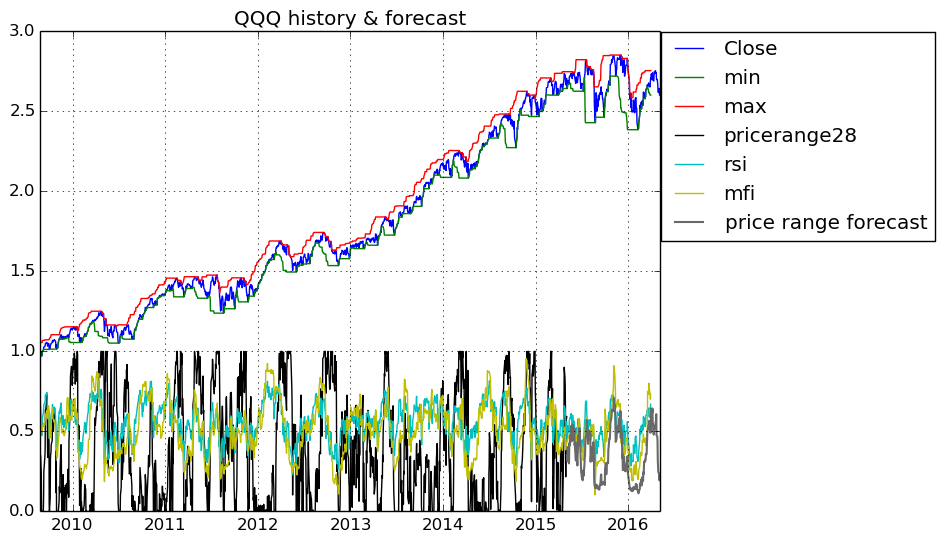

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [132]:
plot(withoutlabel.timestamp,withoutlabel.values[:,closeidx]./initvalue)
plot(withlabel.timestamp,withlabel.values[:,closeidx+1:closeidx+2]./initvalue)
plot(training.timestamp,training.values[:,pricerangeidx],c="k")
plot(withlabel.timestamp,withlabel.values[:,rsiidx],c="c")
plot(withlabel.timestamp,withlabel.values[:,mfiidx],c="y")
plot(newfeatures.timestamp,newlabels,c="DimGrey",linewidth=1.5)
title(symbol*" history & forecast")
grid("on")
legend([withlabel.colnames[[closeidx,closeidx+1,closeidx+2,pricerangeidx,rsiidx,mfiidx]];"price range forecast"],bbox_to_anchor=(1.46, 1.02))

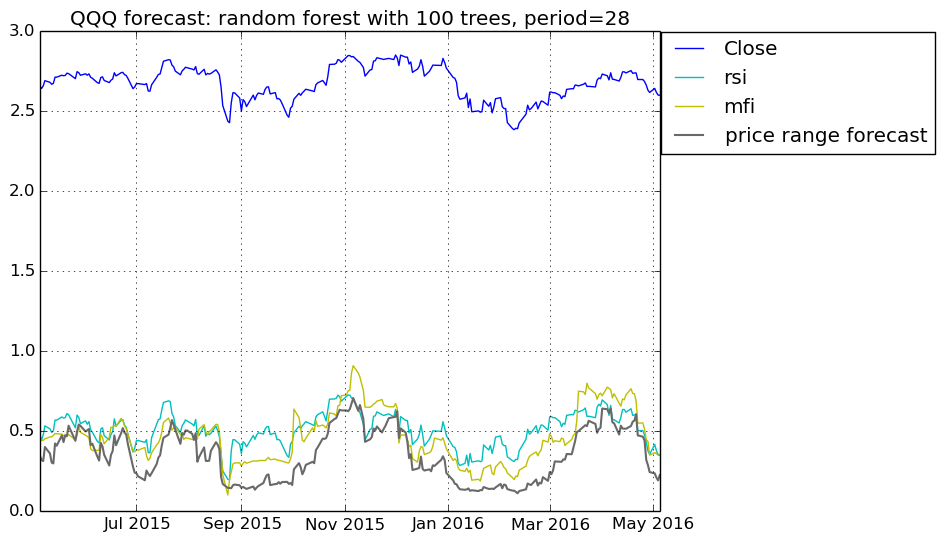

In [133]:
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue,c="b")
plot(newfeatures.timestamp,newfeatures.values[:,rsiidx],c="c")
plot(newfeatures.timestamp,newfeatures.values[:,mfiidx],c="y")
plot(newfeatures.timestamp,newlabels,c="DimGrey",linewidth=1.5)
legend([newfeatures.colnames[[closeidx,rsiidx,mfiidx]];"price range forecast"],bbox_to_anchor=(1.46, 1.02))
title(symbol*" forecast: random forest with "*string(ntrees)*" trees"*", period="*string(rangelength))
grid("on")
# color names http://astropython.blogspot.ie/2012/02/additional-color-names-for-matplotlib.html

In [134]:
features=withlabel.values[:,1:closeidx]
labels=convert(Array{Float64,1},withlabel.values[:,pricerangeidx])
# run n-fold cross validation on regression forest
# using 2 random features, 10 trees, 3 folds, averaging of 5 samples/leaf (optional),
# and 0.7 porition of samples per tree (optional)
# returns array of coefficients of determination (R^2)
r2 = nfoldCV_forest(labels, features, 2, ntrees, 3, 5, 0.7)


Fold 1
Mean Squared Error:     0.03301430596110305
Correlation Coeff:      0.8975811204169653
Coeff of Determination: 0.7126232338555871

Fold 2
Mean Squared Error:     0.03742714731444815
Correlation Coeff:      0.8961463767086401
Coeff of Determination: 0.6920364923193434

Fold 3

3-element Array{Float64,1}:
 0.712623
 0.692036
 0.692959


Mean Squared Error:     0.036378563092793775
Correlation Coeff:      0.8898550942759844
Coeff of Determination: 0.6929588511277167

Mean Coeff of Determination: 0.6992061924342158
